## LASSO Regression

This notebook was adapted from: <br>
Wilmanski et al. (2019). [Blood metabolome predicts gut microbiome alpha-diversity in humans](https://www.nature.com/articles/s41587-019-0233-9#Sec24). Nature biotechnology 37, 1217–1228. <br>
Available at [https://github.com/PriceLab/ShannonMets](https://github.com/PriceLab/ShannonMets)

load libraries

In [1]:
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns
from string import ascii_letters
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

load feature table

In [2]:
discovery_mets=pd.DataFrame.from_csv('../../featuretable_blankfiltered_batchnormalised.tsv', sep = '\t')
discovery_mets.index=discovery_mets.index.astype('float64')
print (discovery_mets.shape)

(9010, 298)


In [3]:
discovery_mets = discovery_mets.T

load metadata

In [6]:
md = pd.DataFrame.from_csv('../../metadata.tsv', sep = '\t')

In [10]:
md = md.drop(list(set(md.index) - set(discovery_mets.index)), axis=0)

In [11]:
list(set(md.index) - set(discovery_mets.index))

[]

In [12]:
md = md.reindex(index=discovery_mets.index)
md = md.reset_index()

# Discovery Cohort Analysis Figure 1

(298, 9010)
AxesSubplot(0.125,0.125;0.775x0.755)


(array([20.,  8., 33., 17., 19., 37., 20., 39., 68., 37.]),
 array([28. , 29.4, 30.8, 32.2, 33.6, 35. , 36.4, 37.8, 39.2, 40.6, 42. ]),
 <a list of 10 Patch objects>)

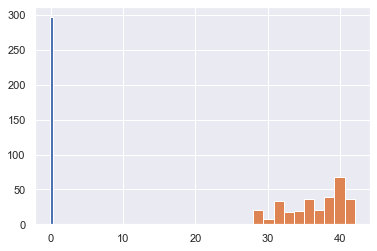

In [15]:
#Scale and standardize metabolites
#X = discovery_mets[discovery_mets.columns[0:659]]
X = discovery_mets
y = (md['Gestationsalder'])
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=X.columns
X = scaler.fit_transform(X)
X=pd.DataFrame(data=X,columns=Xcolumns)
print (X.shape)
sns.set(font_scale=1.00)
#test scaling
print (X[48].hist(bins=50))
#plot histogram of outcome variable shannon
plt.hist(y)

In [16]:
## run cross_val_score on ridge and lasso to get out-of-sample R2 scores across 10-CV
#defining L2 parameters to be tested
alphas = np.linspace(1,1000,200)
#Defining LASSO and Ridge parameters
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
ridgecv=RidgeCV(alphas=alphas,fit_intercept=True,normalize=False,cv=10)
#Running 10-fold CV score function to get mean out-of-sample R2
discovery_score=cross_val_score(lassocv,X,y,cv=10)
print ('mean out-of-sample R2 LASSO',np.mean(discovery_score))
discovery_score_ridge=cross_val_score(ridgecv,X,y,cv=10)
print ('mean out-of-sample R2 Ridge',np.mean(discovery_score_ridge))

mean out-of-sample R2 LASSO 0.47991501658081576
mean out-of-sample R2 Ridge 0.4056923995766448


In [17]:
#Run Cross-validation and extract Beta_coefficients for each model
#Save predictions from each test set
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)

In [18]:
y = (md['Gestationsalder'])
#y=y.reset_index()

In [19]:
#y.drop(['public_client_id'],1,inplace=True)
X_folds = np.array_split(X, 10)
y_folds = np.array_split(y, 10)
coefficients=pd.DataFrame(index=X.columns).astype('float64')
predictions=[]
alphas= []
score= []

In [20]:
for k in range(10):
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    #y_test=[ x[0] for x in  list(y_test.values)]
    y_train = np.concatenate(y_train)
    lassocv.fit(X_train, y_train)
    predictions.append(list(lassocv.predict(X_test).flatten()))
    coef=list(lassocv.coef_)
    coefficients[k]=coef
    alphas.append(lassocv.alpha_)
    score.append(r2_score(y_test,lassocv.predict(X_test)))
#The L1 penalty for each model
print (alphas)
predictions_lasso=[item for sublist in predictions for item in sublist]
#Checking r2 score and pearson r
print ('mean R2 Score LASSO',np.mean(score))
print ('std. deviation for R2 Score',np.std(score))
print ('S.E.M',np.std(score)/np.sqrt(10))
print ('observed v predicted pearson r',stats.pearsonr(md['Gestationsalder'],predictions_lasso))

[0.45245816364735, 0.49959177640320696, 0.452466681187022, 0.4551277259142207, 0.44031305326773257, 0.4423921259673528, 0.4473152875614538, 0.41937723056753656, 0.44738116833967506, 0.41464352836926094]
mean R2 Score LASSO 0.4799150165808158
std. deviation for R2 Score 0.4040700565626841
S.E.M 0.12777817130111493
observed v predicted pearson r (0.7274242293869326, 2.4548111903371643e-50)


In [21]:
score

[0.2978491980995559,
 -0.6660108394770328,
 0.6903572171905359,
 0.5371751905857471,
 0.6531779140275549,
 0.7190866761825556,
 0.6872979352181157,
 0.6917820601881719,
 0.4570698174562645,
 0.7313649963366899]

In [22]:
predictions=pd.DataFrame(index=discovery_mets.index)
predictions['predictions']=predictions_lasso
predictions['shannon']= md['Gestationsalder']
predictions.to_csv("predictions.csv")

## Plot metabolome predicted gestational age versus growth-based gestational age

In [24]:
color = [str(item/255) for item in md['Gestationsalder']]

In [25]:
from matplotlib import cm

In [26]:
len(md['Gestationsalder'])

298

In [27]:
cols = cm.viridis(md['Gestationsalder'])

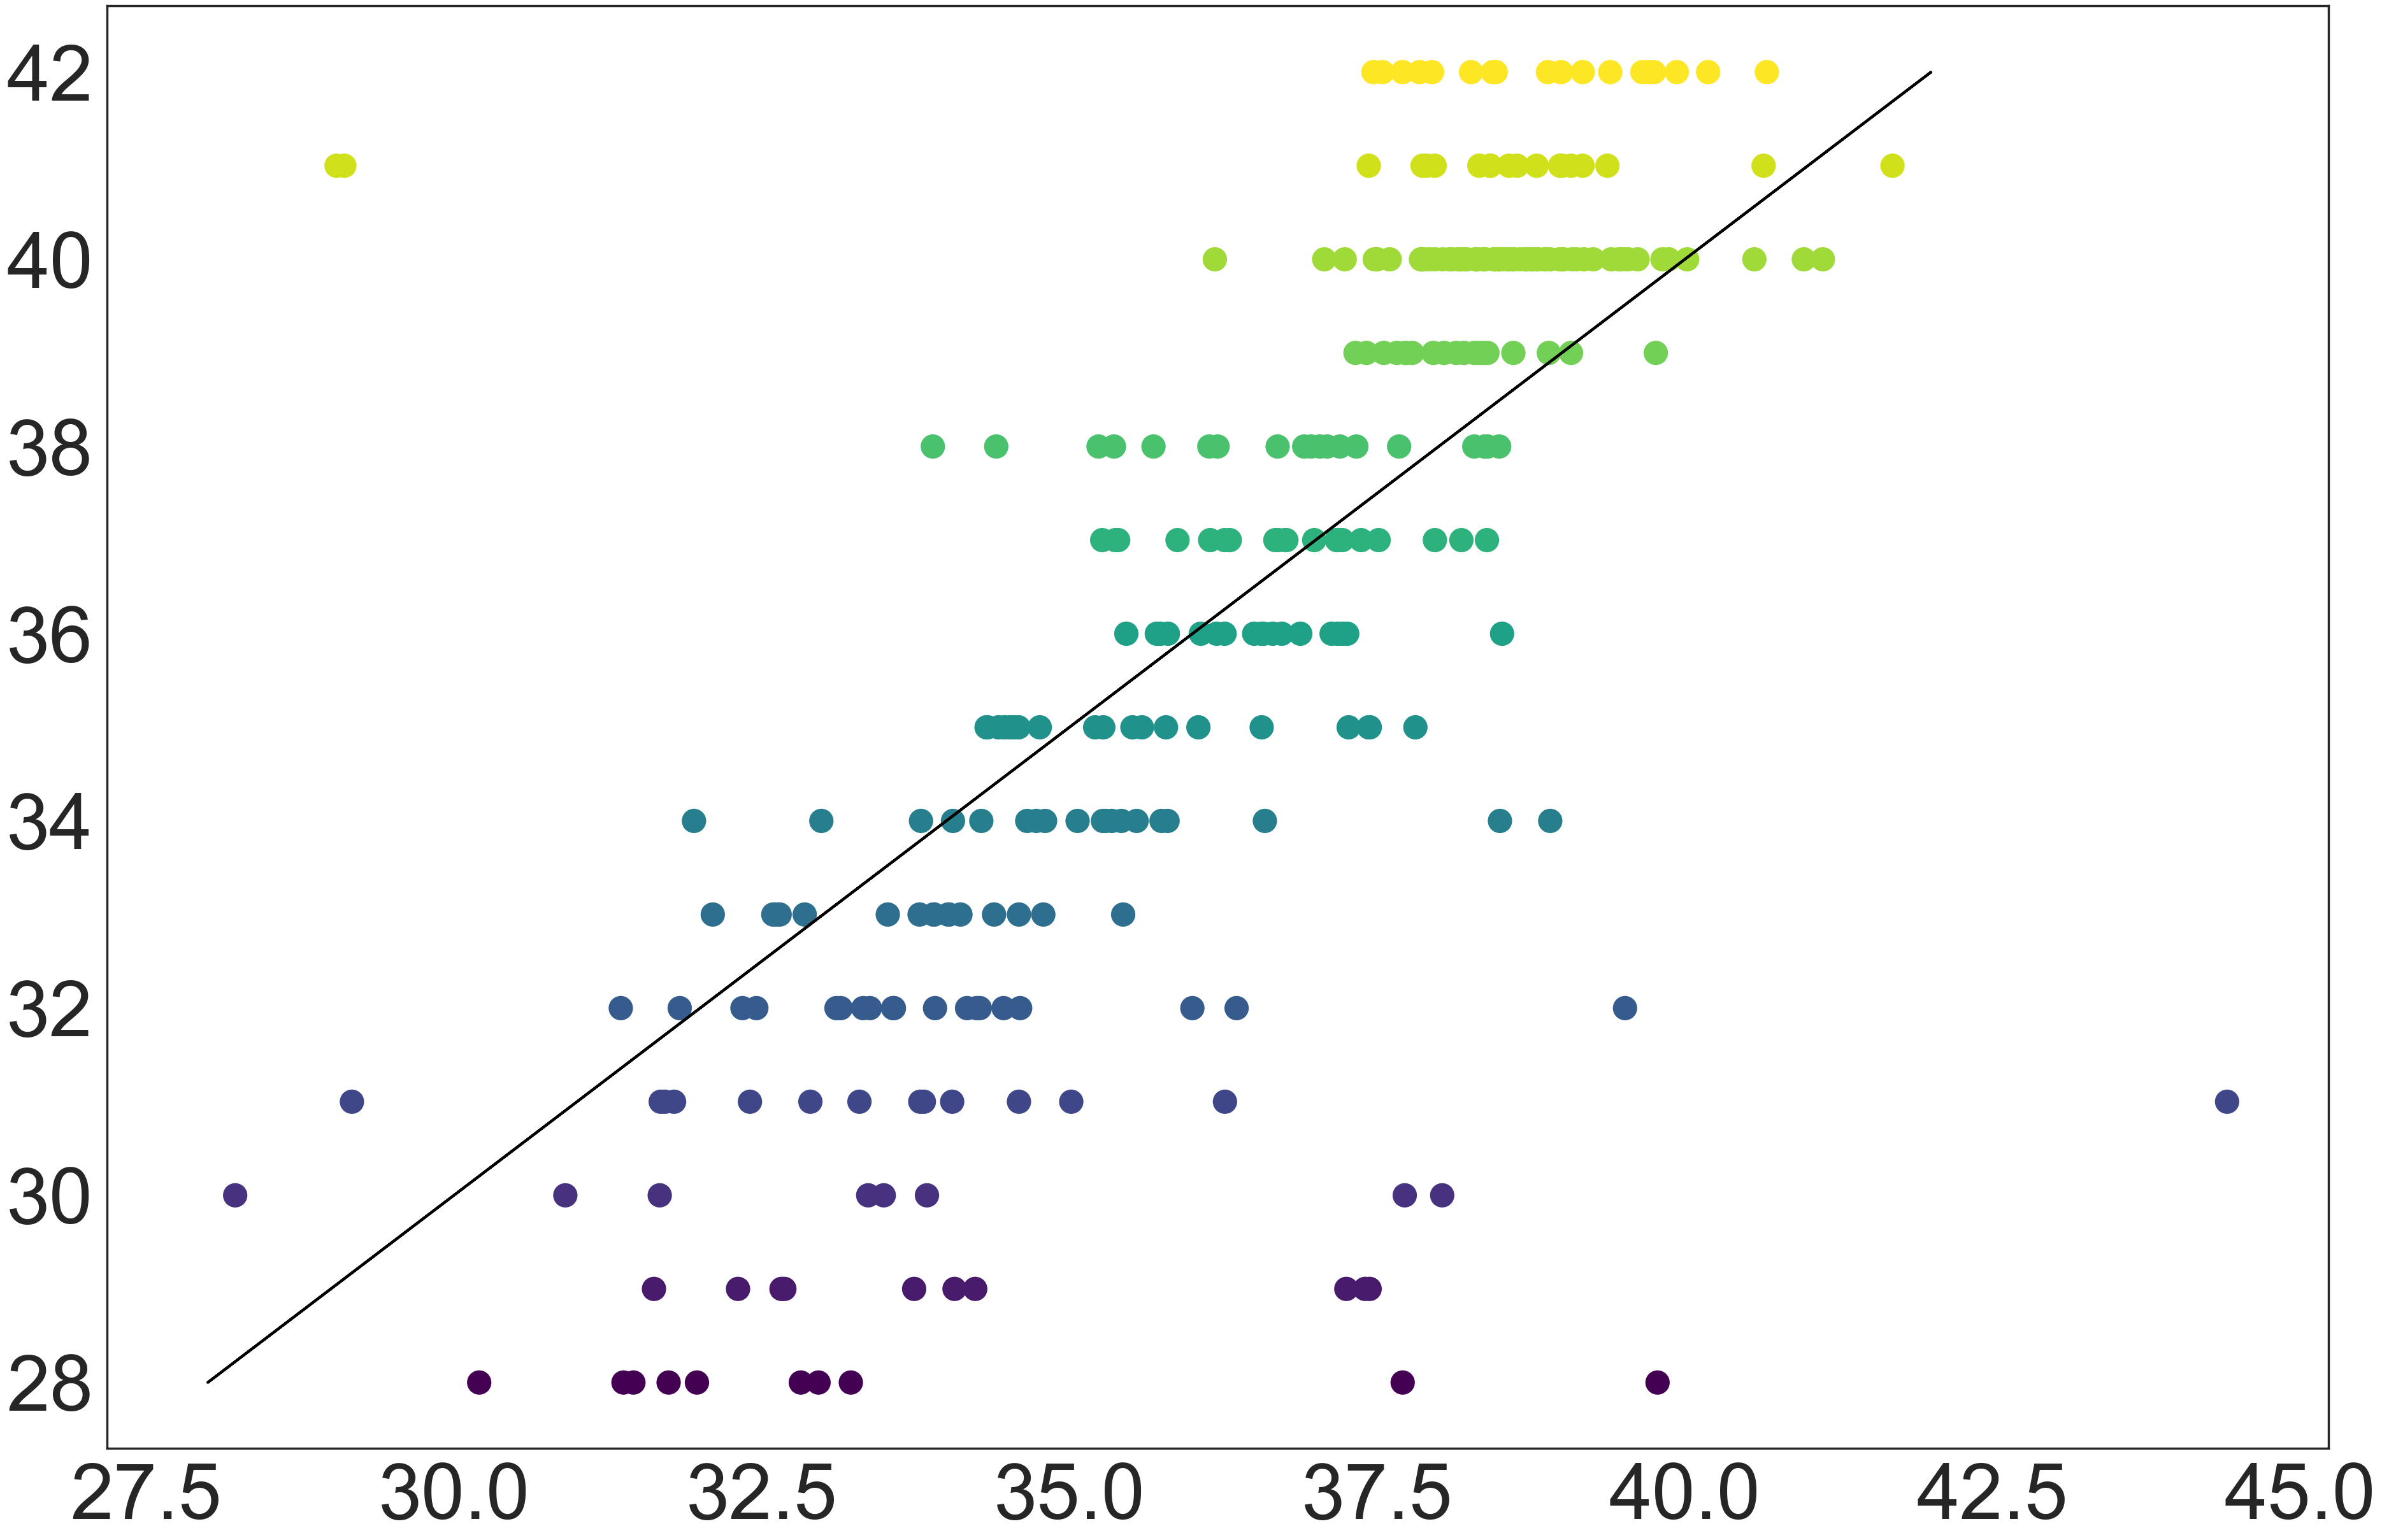

In [30]:
sns.set(font_scale=4.00,context='poster',font='Arial', style='white') # 
plt.figure(figsize=[45,30], dpi=100)
plt.scatter(predictions_lasso, md['Gestationsalder'],s=600,alpha=1,linewidth=3, c=md['Gestationsalder'], cmap='viridis') #color='#440154FF', edgecolors='#440154FF'
plt.plot(y,y,color='black')
plt.savefig('PredictedVsObserved.pdf')

In [31]:
#Identifying all metabolites with non-zero Beta Coefficients for figures 1B&C
for x in coefficients.index.tolist():
    if (coefficients.loc[x] == 0.0).sum()==10:
        coefficients.drop([x],inplace=True)
print (coefficients.shape)
#calculating mean beta-coefficient for each metabolite and counting no. of times each metabolite had a 0 beta-coefficient.
means=[]
std=[]
zeroes=[]
for x in coefficients.index.tolist():
    means.append((np.mean(coefficients.loc[x])))
    std.append((np.std(coefficients.loc[x])))
    zeroes.append((coefficients.loc[x] == 0.0).astype(int).sum())
coefficients['mean']=means
coefficients['std_dev']=std
coefficients['zeroes']=zeroes
#save table as csv
coefficients.to_csv('_coefs.csv')
coefficients.sort_values(by='mean',ascending=True).head()

(83, 10)


,0,1,2,3,4,5,6,7,8,9,mean,std_dev,zeroes
#OTU ID,,,,,,,,,,,,,
4243.0,-0.381421,-0.462388,-0.467076,-0.291529,-0.659288,-0.431063,-0.451499,-0.494254,-0.281563,-0.461414,-0.438150,0.101725,0
2710.0,-0.391476,-0.283469,-0.493952,-0.492796,-0.299883,-0.368141,-0.330157,-0.301465,-0.454891,-0.156575,-0.357281,0.100367,0
8653.0,-0.295547,-0.000000,-0.303972,-0.118867,-0.385291,-0.278371,-0.179525,-0.044573,-0.419716,-0.247526,-0.227339,0.132149,1
9593.0,-0.048486,-0.000000,-0.120111,-0.307736,-0.181288,-0.189154,-0.293293,-0.208323,-0.558611,-0.217091,-0.212409,0.147493,1
79759.0,-0.208065,-0.158706,-0.180779,-0.171860,-0.186504,-0.202026,-0.186371,-0.206144,0.000000,-0.211950,-0.171241,0.059341,1


# Assessing collinearity

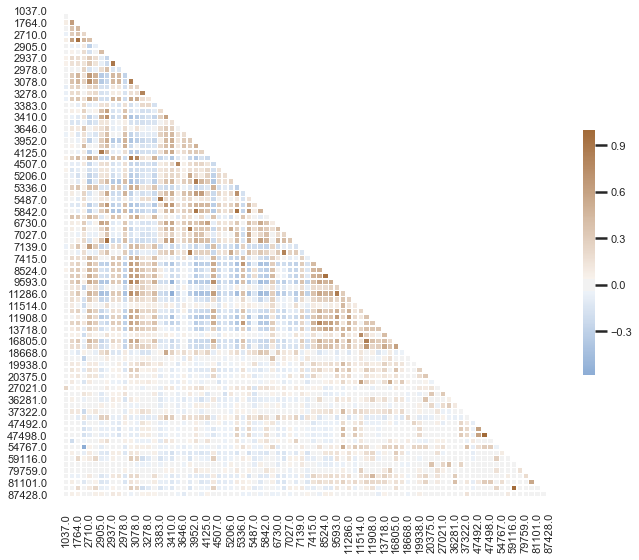

In [35]:
#Select only the 40 identified mets for correlation
corr_df=pd.DataFrame(index=discovery_mets.index)
for x in coefficients.index.tolist():
    corr_df[x]=discovery_mets[x]
#Change metabolite names to just the name (no family, subfamily)
#corr_df.columns=list([x.split(":")[0].split(".")[-1] for x in corr_df.columns.tolist()])
# Compute the correlation matrix
corr = corr_df.corr('pearson')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
sns.set(font_scale=0.50,context='poster',font='Arial',style='white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 40, as_cmap=True)
heatmap=sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap
plt.savefig('heatmap_40_.png',dpi=200)

In [36]:
#no. of corellations >0.80
r=corr.values.flatten()
#remove corelations of metabolites with themselves (r=1)
print (len(r))
r = [x for x in r if x !=1]
print (len(r))
#count number of correlations where absolute value of r>0.80
print (len([i for i in r if abs(i)>0.80]))

6889
6806
40


In [37]:
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
corr_df=pd.DataFrame()
for x in coefficients.index.tolist():
    corr_df[x]=X[x]
corr_df
corr_df=corr_df.corr(method='pearson', min_periods=1)
#corr_df.replace(to_replace=1, value=0, inplace=True, limit=None, regex=False, method='pad')
r=corr_df.values.flatten()
r = [x for x in r if x !=1]
j=[]
j = [i for i in r if i>0.80]
print (len(j))
print (len(r))

40
6806


(array([   6.,    0.,   12.,   50.,   92.,  130.,  218.,  280.,  416.,
         690., 1314.,  860.,  542.,  470.,  392.,  304.,  252.,  182.,
         168.,  128.,  100.,   68.,   40.,   32.,   10.,    6.,   10.,
          16.,    8.,   10.]),
 array([-0.58173587, -0.52901135, -0.47628682, -0.42356229, -0.37083776,
        -0.31811323, -0.2653887 , -0.21266417, -0.15993965, -0.10721512,
        -0.05449059, -0.00176606,  0.05095847,  0.103683  ,  0.15640753,
         0.20913205,  0.26185658,  0.31458111,  0.36730564,  0.42003017,
         0.4727547 ,  0.52547922,  0.57820375,  0.63092828,  0.68365281,
         0.73637734,  0.78910187,  0.8418264 ,  0.89455092,  0.94727545,
         0.99999998]),
 <a list of 30 Patch objects>)

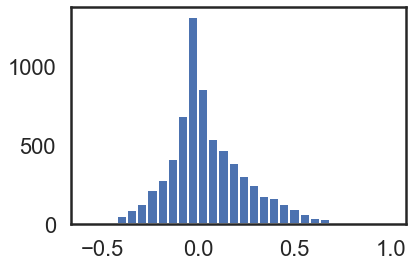

In [38]:
plt.hist(r,bins=30)